In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

读取数据，做数据预处理

In [2]:
train_needing = pd.read_csv('./Data/train_needing.csv')
  test_needing = pd.read_csv('./Data/test_needing.csv')
train_month = pd.read_csv('./Data/train_month.csv')
test_month = pd.read_csv('./Data/test_month.csv')

In [3]:
train_needing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221744 entries, 0 to 221743
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   product_id   221744 non-null  int64  
 1   date         221744 non-null  object 
 2   is_sale_day  221744 non-null  int64  
 3   label        221744 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.8+ MB


In [3]:
train_needing['product_id'] = train_needing['product_id'].astype('str')
train_needing['date'] = train_needing['date'].astype('datetime64')
train_needing['year'] = train_needing['date'].dt.year
train_needing['month'] = train_needing['date'].dt.month

test_needing['product_id'] = test_needing['product_id'].astype('str')
test_needing['date'] = test_needing['date'].astype('datetime64')
test_needing['year'] = test_needing['date'].dt.year
test_needing['month'] = test_needing['date'].dt.month


In [4]:
#根据时间和商品ID作为分组，统计每个商品的月销量
def group_time_product(df):
    df = df.groupby(['year', 'month', 'product_id']).sum().reset_index()
    return df


df_train_needing = group_time_product(train_needing)
df_test_needing = group_time_product(test_needing)
del train_needing, test_needing

In [5]:
#数据类型不一样没办法进行合并，所以需要转换类型
train_month['product_id'] = train_month['product_id'].astype('str')
test_month['product_id'] = test_month['product_id'].astype('str')

In [6]:
df_train = pd.merge(df_train_needing, train_month, on=['year', 'month', 'product_id'], how='left')
df_test = pd.merge(df_test_needing, test_month, on=['year', 'month', 'product_id'], how='left')
del df_train_needing, df_test_needing, train_month, test_month

In [7]:
#处理非字符字段
df_train['year'] = df_train['year'].map({2018: 1, 2019: 2, 2020: 3}) 
df_test['year'] = df_test['year'].map({2018: 1, 2019: 2, 2020: 3, 2021: 4})

In [9]:
"""验证测试集中是否有训练集中不存在的商品ID和类型"""
set1 = set(df_train['product_id'].unique())
set2 = set(df_test['product_id'].unique())
print(len(set2))
print(len(set2.intersection(set1)))

set1 = set(df_train['type'].unique())
set2 = set(df_test['type'].unique())
print(len(set2))
print(len(set2.intersection(set1)))



209
209
3
3


In [8]:
#处理字符字段
df_temp = df_train.append(df_test)
df_temp = pd.get_dummies(df_temp, columns=['type', 'product_id'], drop_first=True)
df_train = df_temp.iloc[:len(df_train)]
df_test = df_temp.iloc[len(df_train):]
del df_temp


In [9]:
#处理缺失值
df_train['start_stock'] = df_train['start_stock'].fillna(df_train['start_stock'].mean())
df_test['start_stock'] = df_test['start_stock'].fillna(df_train['start_stock'].mean())
df_train['end_stock'] = df_train['end_stock'].fillna(df_train['end_stock'].mean())
df_test['end_stock'] = df_test['end_stock'].fillna(df_train['end_stock'].mean())

In [10]:
mm = MinMaxScaler()
mm.fit(df_train[['label', 'order', 'start_stock', 'end_stock']])
df_train[['label', 'order', 'start_stock', 'end_stock']] = mm.transform(df_train[['label', 'order', 'start_stock', 'end_stock']])
df_test[['label', 'order', 'start_stock', 'end_stock']] = mm.fit_transform(df_test[['label', 'order', 'start_stock', 'end_stock']])


In [11]:
#拆分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(['label'], axis = 1),df_train['label'], test_size=0.2, random_state=42)


In [12]:
#准确率计算公式-未区分月份
def accuracy(y_true, y_pred):
    summary = np.sum(y_true)
    return 1 - 1/summary * np.sum(np.abs(y_pred - y_true))

In [34]:
#普通线性回归预测
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_val)

In [35]:
accuracy(y_val, y_pred)

0.18676630738149513

In [53]:
#岭回归预测
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1.7).fit(X_train, y_train)
y_pred = reg.predict(X_val)
accuracy(y_val, y_pred)

0.18708895408407356

<AxesSubplot:>

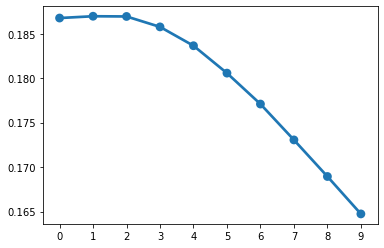

In [67]:
L1 = []
L2 = []
for i in range(10):
    reg = Ridge(alpha=i).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i)
    L2.append(y)
sns.pointplot(x=L1, y=L2)

<AxesSubplot:>

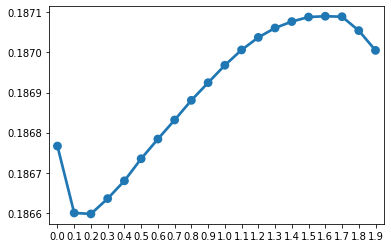

In [68]:
L1 = []
L2 = []
for i in range(20):
    reg = Ridge(alpha = i/10).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i/10)
    L2.append(y)
sns.pointplot(x=L1, y=L2)


In [66]:
#Lasso回归预测
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0).fit(X_train, y_train)
y_pred = reg.predict(X_val)
accuracy(y_val, y_pred)

0.18676658196794071

<AxesSubplot:>

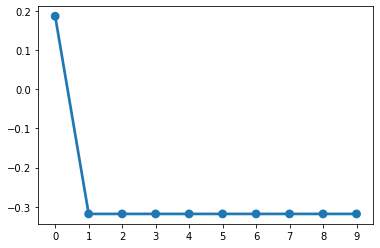

In [69]:
L1 = []
L2 = []
for i in range(10):
    reg = Lasso(alpha=i).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i)
    L2.append(y)
sns.pointplot(x=L1, y=L2)


<AxesSubplot:>

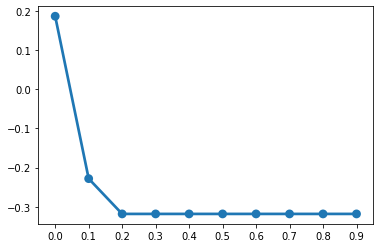

In [70]:
L1 = []
L2 = []
for i in range(10):
    reg = Lasso(alpha=i/10).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i/10)
    L2.append(y)
sns.pointplot(x=L1, y=L2)


In [88]:
#linearsvm预测
from sklearn.svm import LinearSVR
reg = LinearSVR(C=0.1,random_state = 0).fit(X_train, y_train)
y_pred = reg.predict(X_val)
accuracy(y_val, y_pred)

0.31556150250997794

<AxesSubplot:>

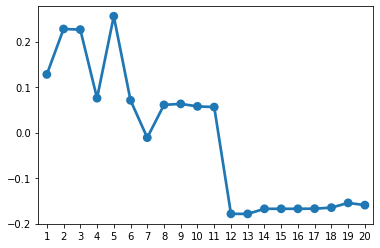

In [91]:
L1 = []
L2 = []
for i in range(1, 21):
    reg = LinearSVR(C=i, random_state=0).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i)
    L2.append(y)
sns.pointplot(x=L1, y=L2)


<AxesSubplot:>

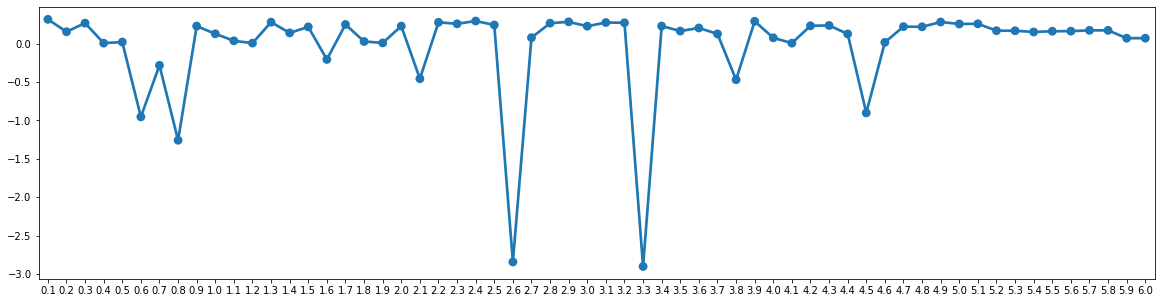

In [95]:
L1 = []
L2 = []
for i in range(1, 61):
    reg = LinearSVR(C=i/10, random_state=0).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i/10)
    L2.append(y)
plt.figure(figsize=(20,5))
sns.pointplot(x=L1, y=L2)


In [115]:
#rbfSVR预测
from sklearn.svm import SVR
reg = SVR(kernel='rbf', C=0.1, gamma=0.1).fit(X_train, y_train)
y_pred = reg.predict(X_val)
accuracy(y_val, y_pred)

-2.698630609135907

In [ ]:
L1 = []
L2 = []
L3 = []
for i in range(1, 11):
    for j in range(1, 11):
        reg = SVR(kernel='rbf', C=i, gamma=j).fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        y = accuracy(y_val, y_pred)
        L1.append(i)
        L2.append(j)
        L3.append(y)


<Figure size 1440x360 with 0 Axes>

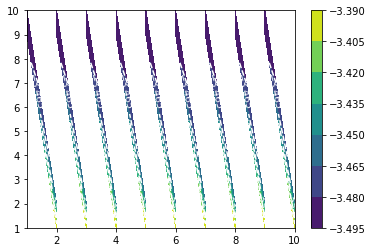

In [112]:
l = len(L1)
thisshape = (-1, 2)  # shape为（y维度,x维度），和前面保持一致~
#对x操作
x = np.array(L1)  # 将list变成array
x.shape = thisshape  # 重新分成符合形状的array
x = np.mat(x).T  # 变成矩阵并转置，因为array没有转置
x = x.A
#对y操作
y = np.array(L2)
y.shape = thisshape
y = np.mat(y).T
y = y.A
#对z操作
z = np.array(L3)
z.shape = thisshape
z = np.mat(z).T
z = z.A
#画图
plt.figure(figsize=(20,5))
plt.clf()
fig, ax = plt.subplots()
lll = ax.contourf(x, y, z)
##画线
contour = ax.contour(x, y, z, colors="white")
##标字
ax.clabel(contour, fontsize=10, colors=('white'))
plt.colorbar(lll)
plt.show()


<Figure size 1440x360 with 0 Axes>

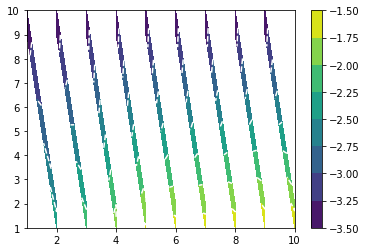

In [113]:
L1 = []
L2 = []
L3 = []
for i in range(1, 11):
    for j in range(1, 11):
        reg = SVR(kernel='rbf', C=i/10, gamma=j/10).fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        y = accuracy(y_val, y_pred)
        L1.append(i)
        L2.append(j)
        L3.append(y)
thisshape = (-1, 2)  # shape为（y维度,x维度），和前面保持一致~
#对x操作
x = np.array(L1)  # 将list变成array
x.shape = thisshape  # 重新分成符合形状的array
x = np.mat(x).T  # 变成矩阵并转置，因为array没有转置
x = x.A
#对y操作
y = np.array(L2)
y.shape = thisshape
y = np.mat(y).T
y = y.A
#对z操作
z = np.array(L3)
z.shape = thisshape
z = np.mat(z).T
z = z.A
#画图
plt.figure(figsize=(20, 5))
plt.clf()
fig, ax = plt.subplots()
lll = ax.contourf(x, y, z)
##画线
contour = ax.contour(x, y, z, colors="white")
##标字
ax.clabel(contour, fontsize=10, colors=('white'))
plt.colorbar(lll)
plt.show()


选用linearSVR，调整数据集，进一步线性化

In [14]:
from sklearn.svm import LinearSVR

In [15]:
df_train['end_stock - start_stock'] = df_train['end_stock'] - df_train['start_stock']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(['label'], axis=1), df_train['label'], test_size=0.2, random_state=42)


In [24]:
reg = LinearSVR(C=0.6, random_state=0).fit(X_train, y_train)
y_pred = reg.predict(X_val)
accuracy(y_val, y_pred)


-0.9603273130200467

<AxesSubplot:>

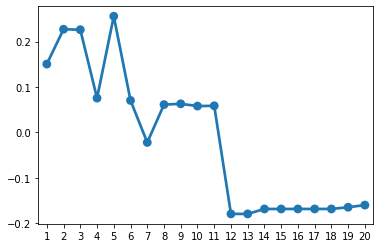

In [25]:
L1 = []
L2 = []
for i in range(1, 21):
    reg = LinearSVR(C=i, random_state=0).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i)
    L2.append(y)
sns.pointplot(x=L1, y=L2)


<AxesSubplot:>

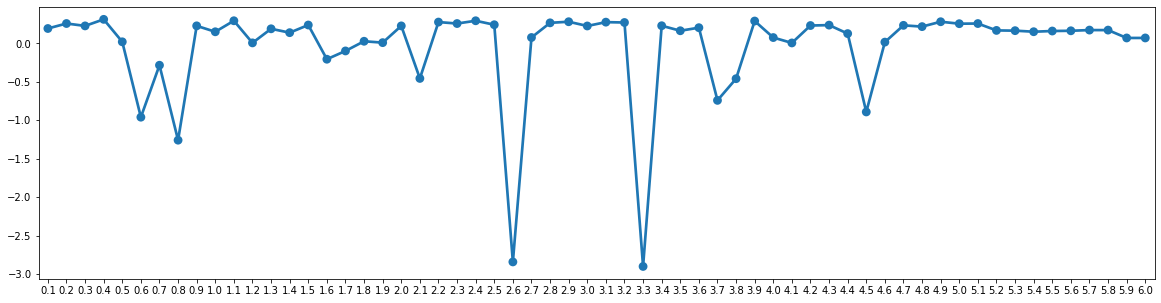

In [26]:
L1 = []
L2 = []
for i in range(1, 61):
    reg = LinearSVR(C=i/10, random_state=0).fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    y = accuracy(y_val, y_pred)
    L1.append(i/10)
    L2.append(y)
plt.figure(figsize=(20, 5))
sns.pointplot(x=L1, y=L2)
